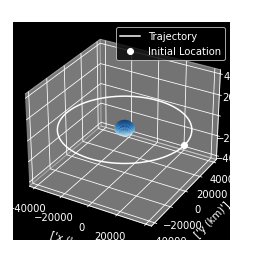

In [1]:
#%% Program for satellite simulation

#%%% Importing libraries
import numpy as np
from numpy import sin
from numpy import cos
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp as ode

#%%% Functions
def twobody_orbit(t, y, mu):
    
    # Unpack state vector
    rx, ry, rz, vx, vy, vz = y
    r = np.array([rx, ry, rz])
    
    # Norm of position vector
    r_norm = np.linalg.norm(r)
    
    # Calculate acceleration
    ax, ay, az = -r*mu / r_norm**3
    
    # Return complete differentiated state vector
    return [vx, vy, vz, ax, ay, az]

def planet_radius(planet_name):
    
    if planet_name == "Earth":
        R = 6371
    else:
        R = 0
        
    return R

def planet_mu(planet_name):
    
    G = 6.67 * 10 ** -11
    
    if planet_name == "Earth":
        M = 5972 * 10 ** 24
        mu = G * M 
    else:
        mu = 0
        
    return mu

def euler_rotation(angle, rotation_element):
    
    # Define rotation matrices
    if rotation_element == 1:
        R = np.array([[1, 0, 0], [0, cos(angle), sin(angle)], [0, -sin(angle), cos(angle)]])
    elif rotation_element == 3:
        R = np.array([[cos(angle), sin(angle), 0], [-sin(angle), cos(angle), 0], [0, 0, 1]])
        
    return R

def rotate_plane(state_matrix, inclination, ascension, argument):
    
    # Unpack state matrix
    r = state_matrix[:3,:]
    v = state_matrix[3:,:]
    
    # Define orbital elements
    i = inclination     # Inclination of orbit (degrees)
    omega = ascension   # Right ascension of the ascending node (degrees)
    w = argument        # Argument of the perigee (degrees)
    
    # Define Euler rotations
    R1_i = euler_rotation(-i, 1)
    R3_omega = euler_rotation(-omega, 3)
    R3_w = euler_rotation(-w, 3)
    
    # Apply Euler rotations
    r = np.matmul(R3_omega, np.matmul(R1_i, np.matmul(R3_w, r)))
    v = np.matmul(R3_omega, np.matmul(R1_i, np.matmul(R3_w, v)))
    
    return np.concatenate((r, v), axis = 0)

def planet_coordinates(planet_name):
    
    # Initialise planet radius
    r = planet_radius(planet_name)
    
    # Set parametric equation limits
    theta, phi = np.mgrid[0 : 2*np.pi : 30j, 0 : np.pi : 20j]
    
    # Compute sphere coordinates
    x = r * cos(theta) * sin(phi)
    y = r * sin(theta) * sin(phi)
    z = r * cos(phi)
    
    return x, y, z
    
def plot(state_matrix, planet_name):
    
    # Unpack state matrix 
    rx = state_matrix[:,0]
    ry = state_matrix[:,1]
    rz = state_matrix[:,2]
    r = [rx, ry, rz]
    
    # Define planet shape coordinates
    x, y, z = planet_coordinates(planet_name)

    # Plot
    plt.rcParams["figure.figsize"] = [18, 6]
    plt.style.use('dark_background')
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    
    # Massive body plot
    ax.plot_surface(x, y, z, cmap = 'Blues')
    x, y, z = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    u, v, w = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    ax.quiver(x, y, z, u, v, w, color ='k')
    
    # Trajectory plot
    ax.plot(rx, ry, rz, 'w', label = 'Trajectory')
    ax.plot(rx[0], ry[0], rz[0], 'wo', label = 'Initial Location')
    
    # Plot parameters
    max_val = np.max(r)
    ax.set_title('Trajectory of satellite')
    ax.set_xlim([-max_val, max_val])
    ax.set_ylim([-max_val, max_val])
    ax.set_zlim([-max_val, max_val])
    ax.set_xlabel(['x (km)'])
    ax.set_ylabel(['y (km)'])
    ax.set_zlabel(['z (km)'])
    plt.legend()
    
#%%% Main program
if __name__ == "__main__":
    
    # Obtain planet properties
    planet = "Earth"
    R = planet_radius(planet)
    mu = planet_mu(planet)
    
    # Initial orbit parameters
    altitude = R + 35800 # km
    v_initial = np.sqrt(mu/altitude) # km / s
    
    # Initial state vector
    r0 = [altitude, 0, 0]
    v0 = [0, v_initial, 0]
    GEO0 = r0 + v0
    
    # Time step
    tspan = np.array([0, 2 * np.pi * np.linalg.norm(r0) / v_initial]) # Period of orbit
    
    # Initialise ODE solver
    solver = ode(twobody_orbit, tspan, GEO0, args = [mu], max_step=0.0001)
    GEO = solver.y
    
    # Rotate states
    GEO = rotate_plane(GEO, 0, 0, 0)
    
    GEO = np.transpose(GEO)
    
    # Plot results
    plot(GEO, planet)